In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s5e1/sample_submission.csv
/kaggle/input/playground-series-s5e1/train.csv
/kaggle/input/playground-series-s5e1/test.csv


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_percentage_error
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor

In [3]:
train_data = pd.read_csv(r"/kaggle/input/playground-series-s5e1/train.csv")
test_data = pd.read_csv(r"/kaggle/input/playground-series-s5e1/test.csv")
#original_data = pd.read_csv(r"/kaggle/input/insurance-prediction-data/Insurance Premium Prediction Dataset.csv")
data = pd.read_csv(r"/kaggle/input/playground-series-s5e1/sample_submission.csv")

print("train_data shape :",train_data.shape)
print("test_data shape :",test_data.shape)
#print("original_data shape :",original_data.shape)
print("data shape :",data.shape)

train_data shape : (230130, 6)
test_data shape : (98550, 5)
data shape : (98550, 2)


In [4]:
train_data.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [5]:
train_data.isna().sum().sort_values(ascending=False)

num_sold    8871
id             0
date           0
country        0
store          0
product        0
dtype: int64

In [6]:
train_data['country'].value_counts()

country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64

In [7]:
train_data = train_data.drop_duplicates()
train_data = train_data.dropna()
print("train_data shape :",train_data.shape)

train_data shape : (221259, 6)


In [8]:
test_data.head()

,id,date,country,store,product
0,230130,2017-01-01,Canada,Discount Stickers,Holographic Goose
1,230131,2017-01-01,Canada,Discount Stickers,Kaggle
2,230132,2017-01-01,Canada,Discount Stickers,Kaggle Tiers
3,230133,2017-01-01,Canada,Discount Stickers,Kerneler
4,230134,2017-01-01,Canada,Discount Stickers,Kerneler Dark Mode


In [9]:
test_data.isna().sum().sort_values(ascending=False)

id         0
date       0
country    0
store      0
product    0
dtype: int64

In [10]:
train_data['date'] = pd.to_datetime(train_data['date'])
test_data['date'] = pd.to_datetime(test_data['date'])

train_data['Year'] = train_data['date'].dt.year
train_data['Month'] = train_data['date'].dt.month
train_data['Day'] = train_data['date'].dt.day
train_data['day_of_week'] = train_data['date'].dt.dayofweek
train_data['day_name'] = train_data['date'].dt.day_name()   # Full name of the day
train_data['quarter'] = train_data['date'].dt.quarter
train_data['is_weekend'] = (train_data['day_of_week'] >= 5).astype(int) # True for Saturday/Sunday
train_data['is_month_start'] = train_data['date'].dt.is_month_start
train_data['is_month_end'] = train_data['date'].dt.is_month_end
train_data['is_year_start'] = train_data['date'].dt.is_year_start
train_data['is_year_end'] = train_data['date'].dt.is_year_end
train_data['month_sin'] = np.sin(2 * np.pi * train_data['Month'] / 12)
train_data['month_cos'] = np.cos(2 * np.pi * train_data['Month'] / 12)
train_data['day_of_week_sin'] = np.sin(2 * np.pi * train_data['day_of_week'] / 7)
train_data['day_of_week_cos'] = np.cos(2 * np.pi * train_data['day_of_week'] / 7)

test_data['Year'] = test_data['date'].dt.year
test_data['Month'] = test_data['date'].dt.month
test_data['Day'] = test_data['date'].dt.day
test_data['day_of_week'] = test_data['date'].dt.dayofweek
test_data['day_name'] = test_data['date'].dt.day_name()   # Full name of the day
test_data['quarter'] = test_data['date'].dt.quarter
test_data['is_weekend'] = (test_data['day_of_week'] >= 5).astype(int) # True for Saturday/Sunday
test_data['is_month_start'] = test_data['date'].dt.is_month_start
test_data['is_month_end'] = test_data['date'].dt.is_month_end
test_data['is_year_start'] = test_data['date'].dt.is_year_start
test_data['is_year_end'] = test_data['date'].dt.is_year_end
test_data['month_sin'] = np.sin(2 * np.pi * test_data['Month'] / 12)
test_data['month_cos'] = np.cos(2 * np.pi * test_data['Month'] / 12)
test_data['day_of_week_sin'] = np.sin(2 * np.pi * test_data['day_of_week'] / 7)
test_data['day_of_week_cos'] = np.cos(2 * np.pi * test_data['day_of_week'] / 7)

In [11]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Fall'

train_data['season'] = train_data['Month'].apply(get_season)
test_data['season'] = test_data['Month'].apply(get_season)

train_data.drop('date',axis=1,inplace=True)
test_data.drop('date',axis=1,inplace=True)

In [12]:
print("train data shape :", train_data.shape)
print("test data shape :", test_data.shape)

train data shape : (221259, 21)
test data shape : (98550, 20)


In [13]:
#train_data.head(2)

In [14]:
train_data['num_sold'] = np.log1p(train_data['num_sold'])

<Axes: >

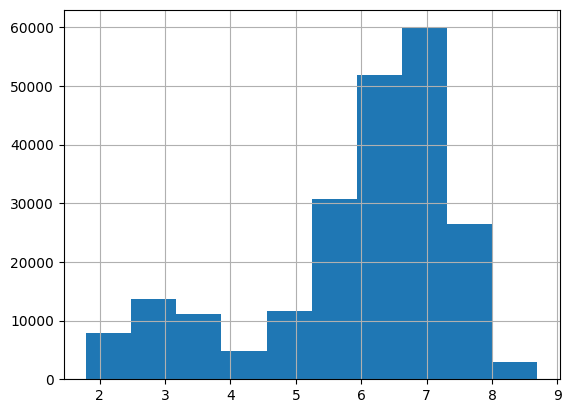

In [15]:
train_data['num_sold'].hist()

In [16]:
train_data = train_data.drop('id', axis = 1)
num_cols = list(train_data.select_dtypes(exclude=['object']).columns.difference(['num_sold']))
cat_cols = list(train_data.select_dtypes(include=['object']).columns)

num_cols_test = list(test_data.select_dtypes(exclude=['object']).columns.difference(['id']))
cat_cols_test = list(test_data.select_dtypes(include=['object']).columns)

In [17]:
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
# Initialize LabelEncoder
label_encoders = {col: LabelEncoder() for col in cat_cols}

# Apply LabelEncoder to each categorical column
for col in cat_cols:
    train_data[col] = label_encoders[col].fit_transform(train_data[col])
    test_data[col] = label_encoders[col].transform(test_data[col])
    

from sklearn.preprocessing import OneHotEncoder
# OneHotEncoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_array = encoder.fit_transform(train_data[cat_cols])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(cat_cols))

# Combine with original DataFrame
train_data = pd.concat([train_data.drop(columns=cat_cols), encoded_df], axis=1)

train_data.shape
# OneHotEncoding
encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded_array = encoder.fit_transform(test_data[cat_cols])
encoded_df = pd.DataFrame(encoded_array, columns=encoder.get_feature_names_out(cat_cols))

# Combine with original DataFrame
test_data = pd.concat([test_data.drop(columns=cat_cols), encoded_df], axis=1)
test_data.shape

In [18]:
train_data = train_data.dropna()
train_data.shape

(221259, 20)

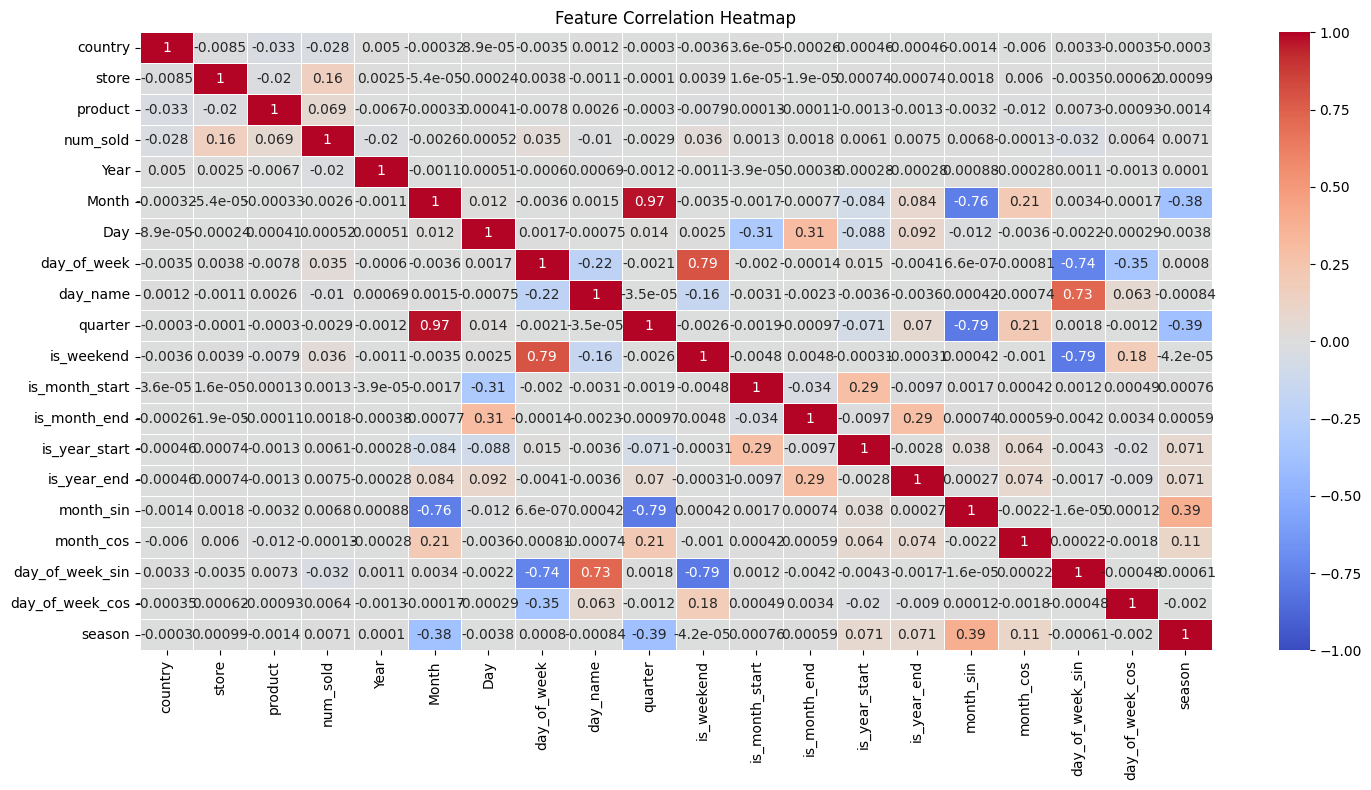

In [19]:
# Calculate the correlation matrix
correlation_matrix = train_data.corr()

# Plot the heatmap
plt.figure(figsize=(15, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, vmin=-1, vmax=1)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

In [20]:
from sklearn.model_selection import train_test_split
X = train_data.drop(['num_sold'], axis=1)
y = train_data['num_sold']
test = test_data.drop(['id'],axis=1)

# Split datainto training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# XGBRegressor:

In [21]:
xgb_parameters = {'n_estimators': 779, 'learning_rate': 0.05040967684293959, 'max_depth': 15, 'min_child_weight': 8, 'subsample': 0.7862803701842613, 'colsample_bytree': 0.826716757679502, 'gamma': 0.030960361476628846, 'reg_alpha': 0.035778578798813854, 'reg_lambda': 2.4687457931229737}
#Best MAPE: 0.0121382097004815
xgb_params = {'n_estimators': 821, 'learning_rate': 0.11099878139668269, 'max_depth': 11, 'min_child_weight': 5, 'subsample': 0.8241822566934365, 'colsample_bytree': 0.690433635572967, 'gamma': 0.00023027742737260527, 'reg_alpha': 2.997952896348801, 'reg_lambda': 7.355442023284021}
#Best MAPE: 0.009360101803685244

In [22]:
paramsxgb = {'n_estimators': 702, 'learning_rate': 0.1316466004260925, 'max_depth': 6, 'min_child_weight': 5, 'subsample': 0.7085976110203339, 'colsample_bytree': 0.9306214290853707, 'gamma': 0.0006666226876864524, 'reg_alpha': 4.783736210532281, 'reg_lambda': 5.162091591648421}
#Best MAPE: 0.00829858896550044

In [23]:
# Define MAPE metric
def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

# Cross-validation for XGBRegressor
def cross_val_xgbr_mape(X, y, test, n_splits=5, **paramsxgb):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mape_scores = []
    preds = []

    for train_index, valid_index in kf.split(X):
        # Ensure data types for indexing
        if isinstance(X, pd.DataFrame):
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        else:
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]

        # Initialize and train the model
        model = XGBRegressor(random_state=42, **paramsxgb)
        model.fit(X_train, y_train)

        # Predictions and evaluation
        y_pred = model.predict(X_valid)
        score = mape(y_valid, y_pred)
        mape_scores.append(score)

        # Predict on the test set
        preds.append(model.predict(test))

    # Average predictions over all folds
    test_preds_mean = np.mean(preds, axis=0)

    return np.mean(mape_scores), test_preds_mean

# Example usage
model_params = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8
}

average_mape, xgb_preds = cross_val_xgbr_mape(X, y, test, n_splits=5, **paramsxgb)

print(f"Average MAPE across folds: {average_mape:.4f}")

# Save predictions for submission
submission = pd.DataFrame({'id': test_data['id'], 'num_sold': np.expm1(xgb_preds)})
print(submission.head())
submission.to_csv('submission_xgb.csv', index=False)


Average MAPE across folds: 0.0083
       id    num_sold
0  230130  157.851044
1  230131  872.232239
2  230132  771.285278
3  230133  399.496246
4  230134  475.060303


In [24]:
# Train final model with best parameters
final_model = XGBRegressor(**paramsxgb)
final_model.fit(X, y)

# Predict on test data
test_preds = final_model.predict(test)

# Save predictions for submission
submission = pd.DataFrame({'id': test_data['id'], 'num_sold': np.expm1(test_preds)})
print(submission.head())
submission.to_csv('submission_xgb_optuna.csv', index=False)

       id    num_sold
0  230130  153.422729
1  230131  866.075623
2  230132  766.288452
3  230133  399.065063
4  230134  480.771851


# LGBMRegressor:

In [25]:
lgb_parameters = {'n_estimators': 719, 'learning_rate': 0.2547321215651838, 'max_depth': -1, 'num_leaves': 93, 'min_child_samples': 12, 'subsample': 0.7469457510257034, 'colsample_bytree': 0.8574364208874832, 'reg_alpha': 0.4432890229534274, 'reg_lambda': 0.5722929283639382, "verbosity" : -1}
lgb_params = {'n_estimators': 957, 'learning_rate': 0.25218721065190347, 'max_depth': 12, 'num_leaves': 141, 'min_child_samples': 30, 'subsample': 0.988782541954839, 'colsample_bytree': 0.8189364609122876, 'reg_alpha': 0.212695135921361, 'reg_lambda': 9.691050961902087, "verbosity" : -1}
#Best MAPE: 0.00818461354433859
lgbparams = {'n_estimators': 500,'subsample': 0.4090842064693564, 'bagging_freq': 5, 'min_data_in_leaf': 49, 'max_depth': 7, 'num_leaves': 345, 'learning_rate': 0.04758672229710525, 'feature_fraction': 0.7906187630443102, 'bagging_fraction': 0.8336404094121244, 'lambda_l1': 0.08518356416922324, 'lambda_l2': 0.01242358754685374, 'min_child_weight': 19, 'colsample_bytree': 0.9765890489522704,'verbosity' : -1}

In [26]:
params = {'n_estimators': 676, 'learning_rate': 0.08093212743989092, 'max_depth': 14, 'num_leaves': 142, 'min_child_samples': 68, 'subsample': 0.6726755900136355, 'colsample_bytree': 0.6668874518641134, 'reg_alpha': 0.017671998955657617, 'reg_lambda': 6.565554062387218}
#Best MAPE: 0.007995846862156795
params = {'n_estimators': 944, 'learning_rate': 0.08000316509887004, 'max_depth': 0, 'num_leaves': 128, 'min_child_samples': 12, 'subsample': 0.7642319654921377, 'colsample_bytree': 0.9634576262735036, 'reg_alpha': 0.22752919356183807, 'reg_lambda': 9.541198845176488}
#Best MAPE: 0.007953764894605874

In [27]:
# Define MAPE metric
def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

# Cross-validation for LGBMRegressor
def cross_val_lgbm_mape(X, y, test, n_splits=5, **params):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mape_scores = []
    preds = []

    for train_index, valid_index in kf.split(X):
        # Ensure data types for indexing
        if isinstance(X, pd.DataFrame):
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        else:
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]

        # Initialize and train the model
        model = LGBMRegressor(random_state=42, **params)
        model.fit(X_train, y_train)

        # Predictions and evaluation
        y_pred = model.predict(X_valid)
        score = mape(y_valid, y_pred)
        mape_scores.append(score)

        # Predict on the test set
        preds.append(model.predict(test))

    # Average predictions over all folds
    test_preds_mean = np.mean(preds, axis=0)

    return np.mean(mape_scores), test_preds_mean

# Example usage
model_params = {
    "n_estimators": 100,
    "learning_rate": 0.1,
    "max_depth": -1,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "verbosity" : -1
}

average_mape, lgb_preds = cross_val_lgbm_mape(X, y, test, n_splits=5, **params)

print(f"Average MAPE across folds: {average_mape:.4f}")

# Save predictions for submission
submission = pd.DataFrame({'id': test_data['id'], 'num_sold': np.expm1(lgb_preds)})
print(submission.head())
submission.to_csv('submission_lgb.csv', index=False)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.012609 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 136
[LightGBM] [Info] Number of data points in the train set: 177007, number of used features: 19
[LightGBM] [Info] Start training from score 5.936249
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008460 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 136
[LightGBM] [Info] Number of data points in the train set: 177007, number of used features: 19
[LightGBM] [Info] Start training from score 5.937891
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008786 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

In [28]:
lgbm_final = LGBMRegressor(**params,random_state=42)
lgbm_final.fit(X_train, y_train)
y_pred = lgbm_final.predict(X_test)
y_pred_test = lgbm_final.predict(test)
print("MAPE:",mean_absolute_percentage_error(y_test, y_pred))
      
# Save predictions for submission
submission = pd.DataFrame({'id': test_data['id'], 'num_sold': np.expm1(y_pred_test)})
print(submission.head())
submission.to_csv('submission_lgb_optuna.csv', index=False)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008916 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 136
[LightGBM] [Info] Number of data points in the train set: 177007, number of used features: 19
[LightGBM] [Info] Start training from score 5.936249
MAPE: 0.007955204061821186
       id    num_sold
0  230130  138.141373
1  230131  860.247556
2  230132  809.331850
3  230133  378.665097
4  230134  459.204659


# CatBoostRegressor:

In [29]:
#cat_params = {'iterations': 938, 'learning_rate': 0.2830337436431764, 'depth': 12, 'l2_leaf_reg': 0.1430918603754631, 'border_count': 165, 'subsample': 0.6337909020045083, 'random_strength': 1.5334270202536981}
#Best MAPE: 0.009599493375975387
cat_params = {'iterations': 873, 'learning_rate': 0.14399876748138352, 'depth': 8, 'l2_leaf_reg': 0.058744021770965237, 'border_count': 40, 'subsample': 0.649263502330531, 'random_strength': 0.00204078361703882}
#Best MAPE: 0.008056446879983767

In [30]:
# Define MAPE metric
def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

# Cross-validation for CatBoostRegressor
def cross_val_catboost_mape(X, y, test, n_splits=5, **cat_params):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    mape_scores = []
    preds = []

    for train_index, valid_index in kf.split(X):
        # Ensure data types for indexing
        if isinstance(X, pd.DataFrame):
            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
        else:
            X_train, X_valid = X[train_index], X[valid_index]
            y_train, y_valid = y[train_index], y[valid_index]

        # Initialize and train the model
        model = CatBoostRegressor(random_state=42, silent=True, **cat_params)
        model.fit(X_train, y_train)

        # Predictions and evaluation
        y_pred = model.predict(X_valid)
        score = mape(y_valid, y_pred)
        mape_scores.append(score)

        # Predict on the test set
        preds.append(model.predict(test))

    # Average predictions over all folds
    test_preds_mean = np.mean(preds, axis=0)

    return np.mean(mape_scores), test_preds_mean

# Example usage
model_params = {
    "iterations": 500,
    "learning_rate": 0.05,
    "depth": 6,
    "loss_function": "MAPE"
}

average_mape, catboost_preds = cross_val_catboost_mape(X, y, test, n_splits=5, **cat_params)

print(f"Average MAPE across folds: {average_mape:.4f}")

# Save predictions for submission
submission = pd.DataFrame({'id': test_data['id'], 'num_sold': np.expm1(catboost_preds)})
print(submission.head())
submission.to_csv('submission_catboost.csv', index=False)


Average MAPE across folds: 0.0079
       id    num_sold
0  230130  135.960804
1  230131  823.518470
2  230132  754.960113
3  230133  377.609874
4  230134  441.113799
